# Titanic Machine Learning Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
full_data = pd.read_csv('../data/train.csv')

In [3]:
full_data.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


### Splitting data into sets for training and testing

In [4]:
X = full_data.drop(['Survived'], axis=1)
y = full_data['Survived']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((712, 11), (712,), (179, 11), (179,))

In [7]:
X_train.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
57,58,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C
717,718,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,S
431,432,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,NaN,1,0,376564,16.1000,NaN,S


In [8]:
#df = df.reset_index()

### Exploring data

In [9]:
df = pd.concat([X_train, y_train], axis=1)

In [10]:
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
57,58,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C,0
717,718,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,S,1


In [11]:
survived_1st = df.loc[(df['Pclass'] == 1) & (df['Survived'] == 0)]
survived_1st.shape

(64, 12)

In [12]:
all_1st = df.loc[df['Pclass'] == 1]
all_1st.shape

(170, 12)

In [13]:
# Percentage of surviving 1st class passengers out of total number of 1st class passengers
80 / 216 * 100

37.03703703703704

<AxesSubplot:xlabel='Pclass', ylabel='count'>

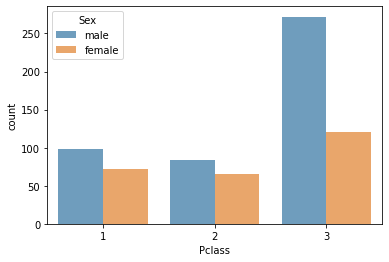

In [14]:
sns.countplot(x='Pclass', hue='Sex', alpha=0.7, data=df)

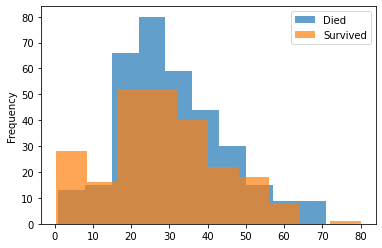

In [15]:
df['Age'].loc[df['Survived'] == 0].plot.hist(alpha=0.7, label='Died')
df['Age'].loc[df['Survived'] == 1].plot.hist(alpha=0.7, label='Survived')
plt.legend()

### Cleaning NaN values

In [16]:
df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            135
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          554
Embarked         2
Survived         0
dtype: int64

<AxesSubplot:>

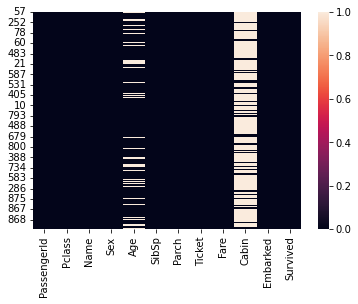

In [17]:
sns.heatmap(df.isna())

Fill 'Embarked' missing values with most frequent port for the 'Pclass' and 'Fare' range.

In [18]:
df['Embarked'].value_counts()

S    523
C    128
Q     59
Name: Embarked, dtype: int64

In [19]:
df.loc[df['Embarked'].isna()]
#Dot notation alternative: df[df.Embarked.isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
61,62,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1
829,830,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1


Relevant commonalities between rows to fill in Embarked values: Pclass = 1, Fare = 80.0

In [20]:
# Exploration of people in first class who paid more than 60 fare (to give a range before 80 of the 2 missing passengers) and where they embarked 
pclass_fare = df[(df['Pclass'] == 1) & (df['Fare'] >= 60)]
pclass_fare['Embarked'].value_counts()

C    42
S    41
Q     2
Name: Embarked, dtype: int64

In [21]:
df['Embarked'].fillna('C', inplace=True)

In [22]:
df.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            135
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          554
Embarked         0
Survived         0
dtype: int64

Check mean Age based on survival.

In [161]:
survived = df.loc[df['Survived'] == 1]
survived['Age'].mean()

28.78828571428571

In [162]:
died = df.loc[df['Survived'] == 0]
died['Age'].mean()

30.281851851851908

Fill 'Age' missing values with mean Age.

In new column, split ages according to child or adult. At the time in 1912, boys would have been considered men on the boat (some crew were apparently thi age) at roughly 13 years old. So 13+ will be considered adult here. This is important since women and children were prioritized in boarding lifeboats.

In [155]:
df['Age'].mean()

29.694494382022487

In [156]:
df['Age'] = df['Age'].fillna(29.69)

In [157]:
df[['Age']].value_counts()

Age  
30.28    92
28.79    43
24.00    25
22.00    24
30.00    22
         ..
20.50     1
14.50     1
12.00     1
10.00     1
80.00     1
Length: 85, dtype: int64

In [158]:
df.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           554
Embarked          0
Survived          0
Cabin Letter      0
dtype: int64

In [159]:
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,Cabin Letter
57,58,3,"Novel, Mr. Mansouer",male,28.5,0,0,2697,7.2292,NaN,C,0,G
717,718,2,"Troutt, Miss. Edwina Celia ""Winnie""",female,27.0,0,0,34218,10.5000,E101,S,1,E


Create a table counting the number of surviving/dead passengers separately for 1st/2nd/3rd class and male/female.

In [160]:
survival_sex = pd.crosstab(index = df['Survived'], columns = df['Sex'])
survival_sex = survival_sex.reset_index()
survival_pclass = pd.crosstab(index = df['Survived'], columns = df['Pclass'])
survival_pclass = survival_pclass.reset_index()
survival_counts = survival_sex.merge(survival_pclass, how='outer')
survival_counts = survival_counts.set_index('Survived')
survival_counts

,female,male,1,2,3
Survived,,,,,
0,68,364,64,76,292
1,190,90,106,73,101


In [31]:
#survival_pclass = df.groupby('Survived')['Pclass']
#survival_pclass.value_counts()

In [32]:
#survival_sex = df.groupby('Survived')['Sex']
#survival_sex.value_counts()

### Baseline model

In [33]:
m_base = DummyClassifier(strategy='most_frequent')
# Also tried strategy='stratified' - m.score was 0.5379
m_base.fit(X_train, y_train)
y_train_pred = m_base.predict(X_train)
m_base.score(X_train, y_train)

0.6067415730337079

In [34]:
m_base.score(X_test, y_test)

0.6536312849162011

### Logistic Regression model

In [35]:
X = full_data[['Pclass']] #independent variables
y = full_data['Survived'] #target variable

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [37]:
m_reg = LogisticRegression()
m_reg.fit(X_train, y_train)
m_reg.score(X_train, y_train)

0.6657303370786517

In [38]:
m_reg.score(X_test, y_test)

0.7318435754189944

In [39]:
m_reg.intercept_, m_reg.coef_

(array([1.37307183]), array([[-0.79538448]]))

Classify all points with a probability > 0.9 as positive.

In [40]:
probabilities = pd.DataFrame(m_reg.predict_proba(X_train).round(2))
probabilities

,0,1
0,0.73,0.27
1,0.55,0.45
2,0.73,0.27
3,0.36,0.64
4,0.73,0.27
...,...,...
707,0.36,0.64
708,0.73,0.27
709,0.36,0.64
710,0.73,0.27


In [41]:
probabilities['new_pred'] = probabilities[1] >= 0.90 
probabilities['new_pred'] = probabilities['new_pred'].astype(int)
probabilities

,0,1,new_pred
0,0.73,0.27,0
1,0.55,0.45,0
2,0.73,0.27,0
3,0.36,0.64,0
4,0.73,0.27,0
...,...,...,...
707,0.36,0.64,0
708,0.73,0.27,0
709,0.36,0.64,0
710,0.73,0.27,0


In [42]:
probabilities['new_pred'].value_counts()

0    712
Name: new_pred, dtype: int64

In [43]:
m_reg.score(X_train, probabilities['new_pred'])

0.7612359550561798

### Binning age data

In [44]:
bins = pd.IntervalIndex.from_tuples([(0, 12), (13, 50), (51, 100)])
full_data['child_adult_older'] = pd.cut(full_data['Age'], bins, labels=['child', 'adult', 'older'])

In [45]:
full_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child_adult_older
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(13, 50]"
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(13, 50]"
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,"(13, 50]"
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,"(13, 50]"
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,"(13, 50]"


In [46]:
full_data['child_adult_older'].value_counts()

(13, 50]     579
(0, 12]       69
(51, 100]     57
Name: child_adult_older, dtype: int64

### Create features using One-Hot Encoding

Create one-hot encoding column for male/female.

In [47]:
pd.get_dummies(full_data['Sex'])

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [48]:
full_data = full_data.merge(pd.get_dummies(full_data['Sex']), left_index=True, right_index=True)
full_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child_adult_older,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(13, 50]",0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(13, 50]",1,0


In [49]:
full_data = full_data.drop(['female'], axis=1)
full_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child_adult_older,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(13, 50]",1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(13, 50]",0


Create one-hot encoding column for age bins.

In [50]:
pd.get_dummies(full_data['child_adult_older'])

,"(0, 12]","(13, 50]","(51, 100]"
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
886,0,1,0
887,0,1,0
888,0,0,0
889,0,1,0


In [51]:
full_data = full_data.merge(pd.get_dummies(full_data['child_adult_older']), left_index=True, right_index=True)
full_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child_adult_older,male,"(0, 12]","(13, 50]","(51, 100]"
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(13, 50]",1,0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(13, 50]",0,0,1,0


In [52]:
full_data = full_data.iloc[: , :-1]
full_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child_adult_older,male,"(0, 12]","(13, 50]"
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(13, 50]",1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(13, 50]",0,0,1


In [63]:
full_data.rename(columns={full_data.columns[-1]: 'adult'}, inplace = True)
full_data.rename(columns={full_data.columns[-2]: 'child'}, inplace = True)
full_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,child_adult_older,male,child,adult
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,"(13, 50]",1,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,"(13, 50]",0,0,1


### Logistic regression w/ added feature 'male'

In [54]:
X = full_data[['Pclass', 'male']] 
y = full_data['Survived']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [56]:
m_reg = LogisticRegression()
m_reg.fit(X_train, y_train)
m_reg.score(X_train, y_train)

0.7780898876404494

In [57]:
m_reg.score(X_test, y_test)

0.8212290502793296

In [58]:
m_reg.intercept_, m_reg.coef_

(array([3.06280347]), array([[-0.89185698, -2.45464709]]))

In [59]:
m_reg.predict_proba(X_train).round(2)

array([[0.89, 0.11],
       [0.22, 0.78],
       [0.4 , 0.6 ],
       ...,
       [0.57, 0.43],
       [0.89, 0.11],
       [0.76, 0.24]])

### Logistic regression - Pclass, male, age bins

In [64]:
X = full_data[['Pclass', 'male', 'child', 'adult']] 
y = full_data['Survived']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [66]:
m_reg = LogisticRegression()
m_reg.fit(X_train, y_train)
m_reg.score(X_train, y_train)

0.7780898876404494

In [67]:
m_reg.score(X_test, y_test)

0.8379888268156425

In [68]:
m_reg.intercept_, m_reg.coef_

(array([3.08875677]),
 array([[-0.93986013, -2.42076337,  0.8383373 , -0.01602037]]))

In [69]:
m_reg.predict_proba(X_train).round(2)

array([[0.9 , 0.1 ],
       [0.23, 0.77],
       [0.43, 0.57],
       ...,
       [0.57, 0.43],
       [0.79, 0.21],
       [0.77, 0.23]])

### More feature engineering with OHE - cabin letters


Fill 'Cabin' missing values: Fill new column 'Cabin Letter' missing values based on probability of letter per 'Pclass'

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 57 to 265
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  712 non-null    int64  
 1   Pclass       712 non-null    int64  
 2   Name         712 non-null    object 
 3   Sex          712 non-null    object 
 4   Age          712 non-null    float64
 5   SibSp        712 non-null    int64  
 6   Parch        712 non-null    int64  
 7   Ticket       712 non-null    object 
 8   Fare         712 non-null    float64
 9   Cabin        158 non-null    object 
 10  Embarked     712 non-null    object 
 11  Survived     712 non-null    int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 88.5+ KB


In [71]:
df.loc[df['Cabin'].isna()].head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
57,58,3,"Novel, Mr. Mansouer",male,28.50,0,0,2697,7.2292,NaN,C,0
431,432,3,"Thorneycroft, Mrs. Percival (Florence Kate White)",female,28.79,1,0,376564,16.1000,NaN,S,1
633,634,1,"Parr, Mr. William Henry Marsh",male,30.28,0,0,112052,0.0000,NaN,S,0
163,164,3,"Calic, Mr. Jovo",male,17.00,0,0,315093,8.6625,NaN,S,0
864,865,2,"Gill, Mr. John William",male,24.00,0,0,233866,13.0000,NaN,S,0


In [72]:
# Create new column with first letter of Cabin names
df['Cabin Letter'] = df['Cabin'].str[0]
df['Cabin Letter'].value_counts()

C    45
B    35
D    27
E    25
A    11
F    10
G     4
T     1
Name: Cabin Letter, dtype: int64

Get probability of each Cabin Letter appearing in a certain Pclass.

In [73]:
# Getting overview of number per cabins per letter per class
cabin_lets = pd.crosstab(index=df['Pclass'], columns=df['Cabin Letter'], margins=True)
cabin_lets

Cabin Letter,A,B,C,D,E,F,G,T,All
Pclass,,,,,,,,,
1,11,35,45,24,19,0,0,1,135
2,0,0,0,3,4,6,0,0,13
3,0,0,0,0,2,4,4,0,10
All,11,35,45,27,25,10,4,1,158


In [74]:
# Same overview, different method
#class_cabinlets = df.groupby('Pclass')['Cabin Letter']
#class_cabinlets.value_counts()

In [75]:
prob_c1 = df.loc[df['Pclass'] == 1]['Cabin Letter'].value_counts(normalize=True)
prob_c1

C    0.333333
B    0.259259
D    0.177778
E    0.140741
A    0.081481
T    0.007407
Name: Cabin Letter, dtype: float64

In [76]:
prob_c2 = df.loc[df['Pclass'] == 2]['Cabin Letter'].value_counts(normalize=True)
prob_c2

F    0.461538
E    0.307692
D    0.230769
Name: Cabin Letter, dtype: float64

In [77]:
prob_c3 = df.loc[df['Pclass'] == 3]['Cabin Letter'].value_counts(normalize=True)
prob_c3

G    0.4
F    0.4
E    0.2
Name: Cabin Letter, dtype: float64

Replace missing Cabin Letter values with values weighted by probability for each Pclass.

In [78]:
missing_c1 = (df['Pclass'] == 1) & (df['Cabin Letter'].isna())
missing_c1

57     False
717    False
431    False
633     True
163    False
       ...  
369    False
320    False
527    False
125    False
265    False
Length: 712, dtype: bool

In [79]:
df.loc[missing_c1, 'Cabin Letter'] = np.random.choice(prob_c1.index, size=len(df[missing_c1]), p=prob_c1.values)
df.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           554
Embarked          0
Survived          0
Cabin Letter    519
dtype: int64

In [80]:
missing_c2 = (df['Pclass'] == 2) & (df['Cabin Letter'].isna())
missing_c2

57     False
717    False
431    False
633    False
163    False
       ...  
369    False
320    False
527    False
125    False
265     True
Length: 712, dtype: bool

In [81]:
df.loc[missing_c2, 'Cabin Letter'] = np.random.choice(prob_c2.index, size=len(df[missing_c2]), p=prob_c2.values)
df.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           554
Embarked          0
Survived          0
Cabin Letter    383
dtype: int64

In [82]:
missing_c3 = (df['Pclass'] == 3) & (df['Cabin Letter'].isna())
missing_c3

57      True
717    False
431     True
633    False
163     True
       ...  
369    False
320     True
527    False
125     True
265    False
Length: 712, dtype: bool

In [83]:
df.loc[missing_c3, 'Cabin Letter'] = np.random.choice(prob_c3.index, size=len(df[missing_c3]), p=prob_c3.values)
df.isna().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin           554
Embarked          0
Survived          0
Cabin Letter      0
dtype: int64

One-Hot encode cabin letters.

In [84]:
pd.get_dummies(df['Cabin Letter'])

,A,B,C,D,E,F,G,T
57,0,0,0,0,0,0,1,0
717,0,0,0,0,1,0,0,0
431,0,0,0,0,1,0,0,0
633,0,0,1,0,0,0,0,0
163,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...
369,0,1,0,0,0,0,0,0
320,0,0,0,0,0,1,0,0
527,0,0,1,0,0,0,0,0
125,0,0,0,0,0,0,1,0


In [85]:
full_data = full_data.merge(pd.get_dummies(df['Cabin Letter']), left_index=True, right_index=True)
full_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,child,adult,A,B,C,D,E,F,G,T
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,...,0,1,0,0,0,0,1,0,0,0


In [86]:
alphabet = full_data[['A', 'B', 'C', 'D', 'E', 'F','G','T']]
alphabet.value_counts().sum()

712

### Logistic regression incl. cabin letters

In [126]:
X = full_data[['Pclass', 'male', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']]
y = full_data['Survived']

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [139]:
m_reg = LogisticRegression()
m_reg.fit(X_train, y_train)
m_reg.score(X_train, y_train)

0.7768014059753954

In [140]:
m_reg.score(X_test, y_test)

0.7832167832167832

In [141]:
m_reg.intercept_, m_reg.coef_

(array([3.33041089]),
 array([[-1.08571207, -2.42518342, -0.19119787, -0.06328059, -0.3923599 ,
         -0.00334508,  0.06922402,  0.15796156,  0.78990183, -0.36638417]]))

In [142]:
m_reg.predict_proba(X).round(2)

array([[0.83, 0.17],
       [0.46, 0.54],
       [0.14, 0.86],
       ...,
       [0.1 , 0.9 ],
       [0.64, 0.36],
       [0.91, 0.09]])

In [143]:
probabilities = pd.DataFrame(m_reg.predict_proba(X_train).round(2))
#probabilities

In [144]:
probabilities['new_pred'] = probabilities[1] >= 0.60 
probabilities['new_pred'] = probabilities['new_pred'].astype(int)
#probabilities

In [145]:
probabilities['new_pred'].value_counts()

0    420
1    149
Name: new_pred, dtype: int64

In [146]:
m_reg.score(X_train, probabilities['new_pred'])

0.8927943760984183

### Decision Tree model

In [97]:
X = full_data[['Pclass', 'male', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']] 
y = full_data['Survived']

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [99]:
m_dt = DecisionTreeClassifier(max_depth=1)

In [100]:
m_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=1)

In [101]:
y_train_pred = m_dt.predict(X_train)
#y_train_pred

In [102]:
m_dt.score(X_train, y_train)

0.7768014059753954

In [103]:
accuracy_score(y_train_pred, y_train)

0.7768014059753954

[Text(167.4, 163.07999999999998, 'male <= 0.5\ngini = 0.481\nsamples = 569\nvalue = [340, 229]\nclass = Died'),
 Text(83.7, 54.360000000000014, 'gini = 0.382\nsamples = 210\nvalue = [54, 156]\nclass = Survived'),
 Text(251.10000000000002, 54.360000000000014, 'gini = 0.324\nsamples = 359\nvalue = [286, 73]\nclass = Died')]

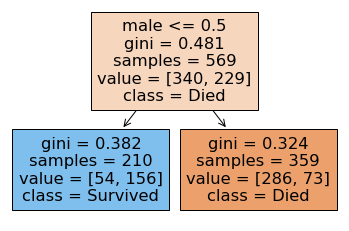

In [104]:
plt.figure()
plot_tree(m_dt, filled=True, feature_names=['Pclass', 'male',  'A', 'B', 'C', 'D', 'E', 'F','G','T'], class_names=['Died', 'Survived',])

### Random Forest model

In [118]:
X = full_data[['Pclass', 'male']] 
y = full_data['Survived']

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [120]:
m_rf = RandomForestClassifier(n_estimators=100, max_depth=1, max_features=1)

In [121]:
m_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=1, max_features=1)

In [122]:
m_rf.score(X_train, y_train)

0.773286467486819

In [123]:
m_rf.score(X_test, y_test)

0.7902097902097902




### Work in progress:
### One-Hot Encoding age bins using Column Transformer:

#full_data_original = full_data.drop(['male', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], axis=1)
#full_data_original.head(2)

categorical_ohe = ['child_adult_old']
other = ['Age', 'Fare', 'Name', 'Parch', 'SibSp', 'Ticket', 'PassengerId', 'Cabin', 'Pclass', 'Sex', 'Embarked']

trans = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse=False, handle_unknown='error', drop='first'), categorical_ohe),
    ('ignore', 'passthrough', other)
])

df_trans = trans.fit_transform(df)

df_trans

### Pipeline - imputing and scaling data

impute_and_scale = make_pipeline(SimpleImputer(), MinMaxScaler())


...
('impute and scale', impute_and_scale, ['Age', 'Fare']),
...

### Calculate train and validation accuracy


confusion_matrix(y, y_pred)

ConfusionMatrixDisplay.from_predictions(y, ypred, normalize=None)

### Cabin Numbers feature engineering

- Determine pool of available/unused cabin numbers per letter
- Append 'Cabin Letter' with random value from cabin numbers pool

Classify cabins based on whether they were on the port or starboard side of the ship. Research shows that even-numbered cabins were on the port side and odd-numbered on the starboard side. This is relevant because the officers letting people on lifeboats had different policies on either side. The one on the port side allowed NO MEN on the lifeboats, whereas the one of the starboard side allowed SOME MEN on the lifeboats but prioritized women and children.

Append Cabin Letters with Cabin Numbers according to remaining/unused cabin numbers in dataset for that letter.

df.head(3)

### Extract only numbers from Cabin column and put into new Cabin Number column where \d+ refers to regex for all digits (not just first digit without '+')
df['Cabin Number'] = df['Cabin'].str.extract('(\d+)')
df['Cabin Number'] = df['Cabin Number'].dropna().astype(int)
df['Cabin Number'].unique()

### Convert Cabin Number values into integers
#cabin_nums = df.loc[df['Cabin Number'].notna()]
#cabin_nums['Cabin Number'] = cabin_nums['Cabin Number'].astype(int)
#cabin_nums['Cabin Number'].unique()

#df['Cabin Number'] = df.loc[df['Cabin Number'].notna()].astype(int)

cabin_evens = df[df['Cabin Number'] % 2 == 0]
cabin_evens

cabin_odds = df[df['Cabin Number'] % 2 != 0]
cabin_odds

prob_even = df['Cabin Number'] % 2
prob_even.value_counts(normalize=True)

df.loc[missing_c3, 'Cabin Letter'] = np.random.choice(prob_c3.index, size=len(df[missing_c3]), p=prob_c3.values)
df.isna().sum()

df.loc[df.Survived==1];

g_pclass = df.groupby('Pclass')
g_sex = df.groupby('Sex')
g_survived = df.groupby('Survived') 

survived_f = (df['Sex'] == 'female') & (df['Survived'] == 1)
survived_f

died_count = df.loc[df['Survived'] == 0].count()
died_count

#survival_counts = pd.DataFrame([[df.loc[df['Pclass'] == 1].count(df['Survived']), df.loc[df['Pclass'] == 2].count(df['Survived']), df.loc[df['Pclass'] == 3].count(df['Survived']), df.loc[df['Sex'] == 'female'].count(df['Survived']), df.loc[df['Sex'] == 'male'].count(df['Survived'])]], 
                               #columns=['class_1', 'class_2', 'class_3', 'female', 'male'], 
                               #index=None)
##survival_counts

df.groupby('Survived').nunique()
### See survival counts per column

df.groupby('Pclass')['Survived'].value_counts()

df.groupby('Sex')['Survived'].value_counts()